# Explainer

---

## Load Data Split

In [2]:
import pandas as pd

X_train = pd.read_csv("../CICIDS2017/train_test_split/X_train_small.csv")
X_test = pd.read_csv("../CICIDS2017/train_test_split/X_test_small.csv")
y_train = pd.read_csv("../CICIDS2017/train_test_split/y_train_small.csv")
y_test = pd.read_csv("../CICIDS2017/train_test_split/y_test_small.csv")

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2000, 70) (500, 70) (2000, 2) (500, 2)


## Import Model

In [4]:
# load model
from tensorflow import keras

model = keras.models.load_model('../CICIDS2017/models/ids_dnn_small.keras')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 50)             │         3,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 30)             │         1,530 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           310 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            22 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,238 (63.43 KB)

 Trainable params: 5,412 (21.14 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 10,826 (42.29 KB)

## Extract SHAP Values

In [5]:
# extract SHAP values
import shap
import numpy as np


# Initialize SHAP explainer
explainer = shap.Explainer(model, X_test, feature_names=X_test.columns)
shap_values = explainer(X_test)


print(shap_values.shape)

PermutationExplainer explainer: 501it [00:32, 12.67it/s]                         

(500, 70, 2)


## Plot SHAP Values

In [6]:
# convert shap values to correct format
print(shap_values.shape) # one shap value per feature per sample per class
shap_values = shap_values[:, :, 0] # 1 == Benign, 0 == Malicious
print(shap_values.shape) # one shap value per feature per sample

(500, 70, 2)
(500, 70)


### Local Models

#### Benign Class

0


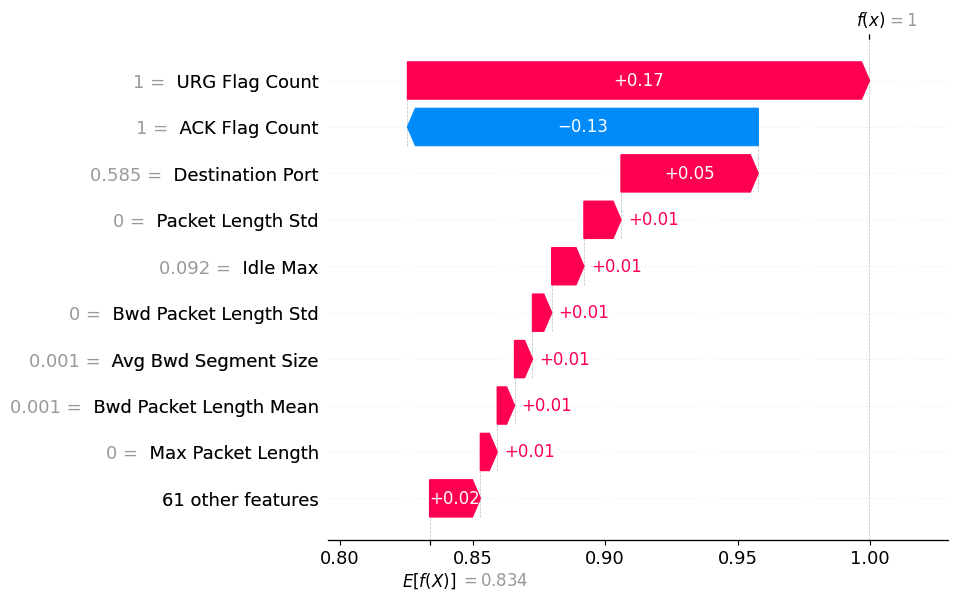

In [12]:
# plot explanations from bengin class
benign_classes = np.array(y_test[y_test['BENIGN'] == 1].index)
first_benign_index = benign_classes[0]
print(first_benign_index)
shap.waterfall_plot(shap_values[first_benign_index])

#### Malicious Class

9


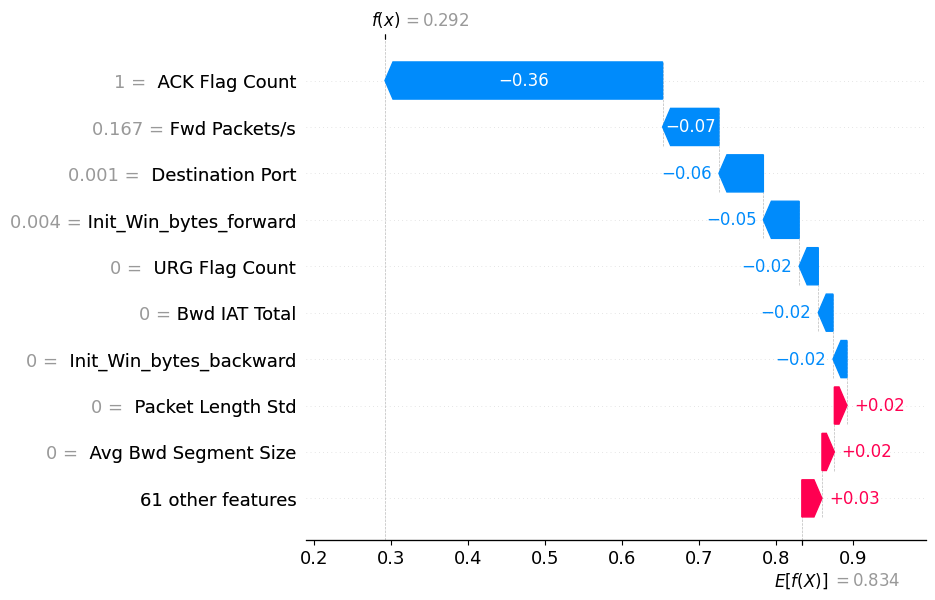

In [13]:
# plot explanations from malicious class
malicious_classes = np.array(y_test[y_test['MALICIOUS'] == 1].index)
first_malicious_index = malicious_classes[0]
print(first_malicious_index)
shap.waterfall_plot(shap_values[first_malicious_index])

### Global Models

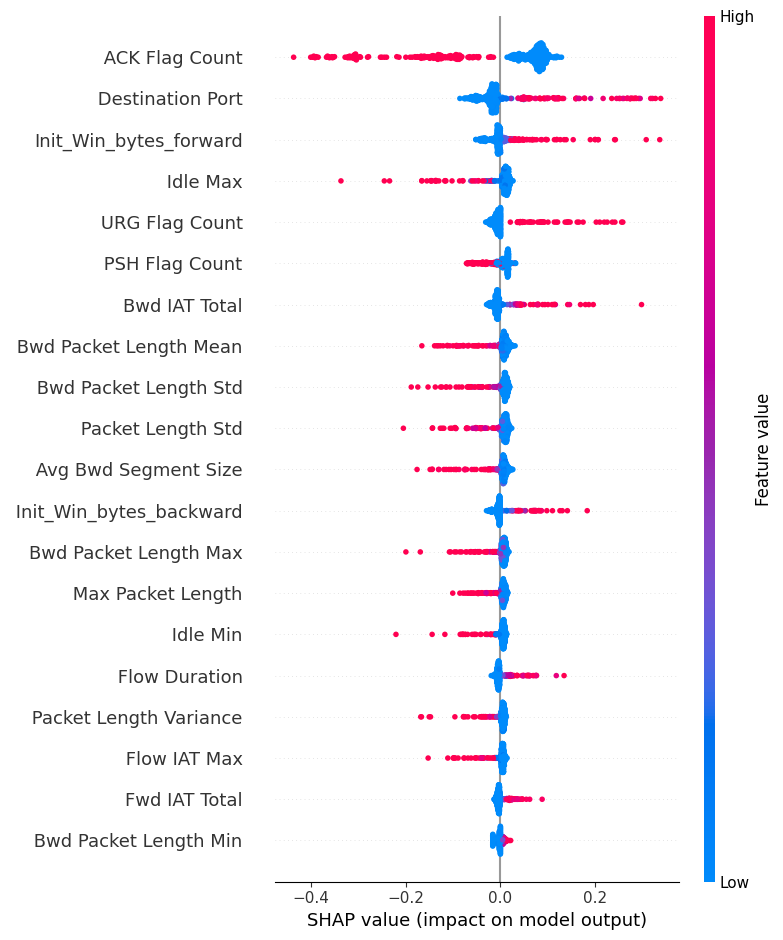

In [14]:
# summary plot
shap.summary_plot(shap_values, X_test)

#### Mean SHAP Values for Benign Class

Shap values shape: (500, 70)
Benign classes shape: (416,)
Benign shape values shape: (416, 70)


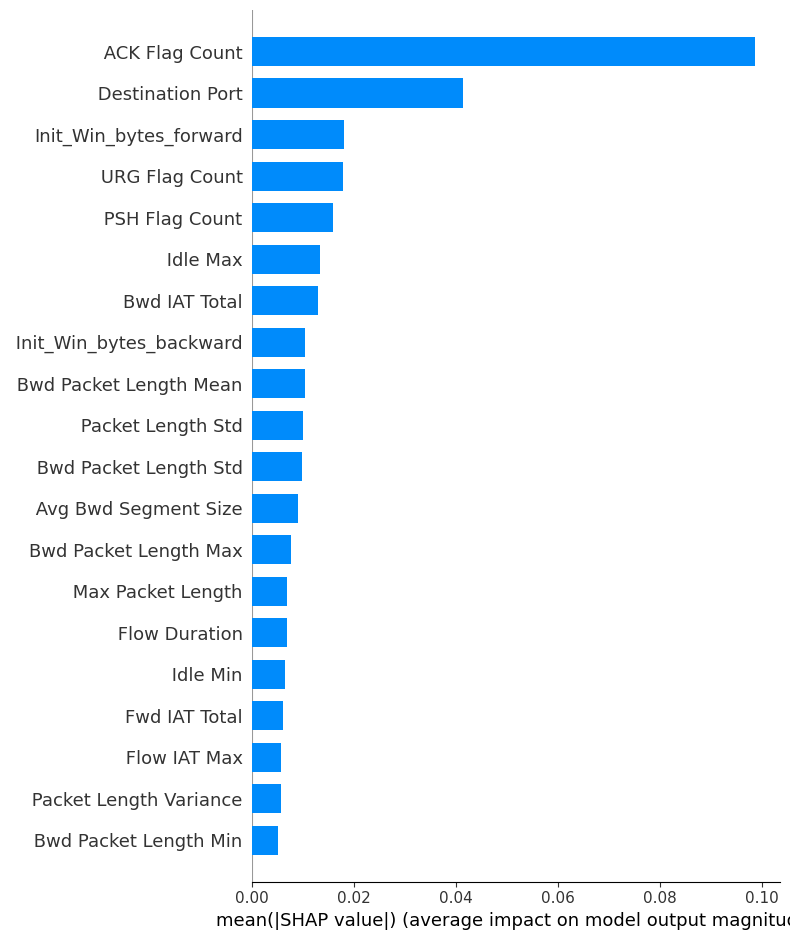

In [15]:
print(f"Shap values shape: {shap_values.shape}")
print(f"Benign classes shape: {benign_classes.shape}")

benign_shape_values = shap_values[benign_classes]
print(f"Benign shape values shape: {benign_shape_values.shape}")
shap.summary_plot(benign_shape_values, X_train, plot_type="bar")


#### MEAN SHAP Values for Malicious Class

Shap values shape: (500, 70)
Benign classes shape: (84,)
Benign shape values shape: (84, 70)


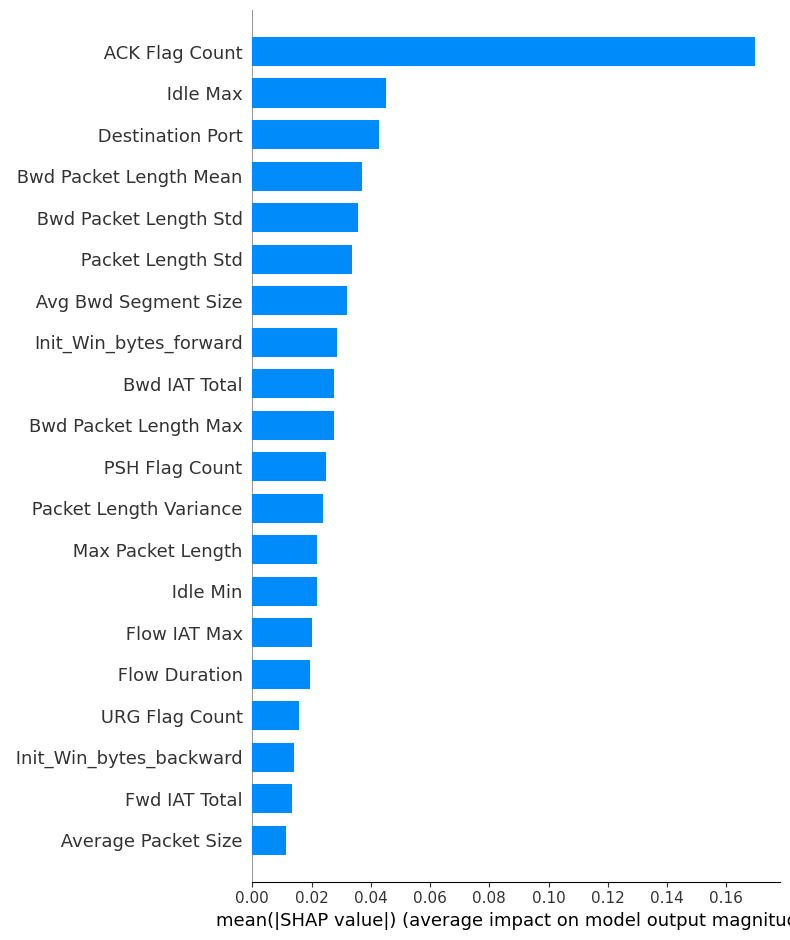

In [16]:
print(f"Shap values shape: {shap_values.shape}")
print(f"Benign classes shape: {malicious_classes.shape}")

malicious_shape_values = shap_values[malicious_classes]
print(f"Benign shape values shape: {malicious_shape_values.shape}")
shap.summary_plot(malicious_shape_values, X_train, plot_type="bar")


--- 

## Adversarial Explanations

In [17]:
# load adversarial sample
X_test_adv = pd.read_csv("../CICIDS2017/adversarial_samples/X_test_small_adv_fgsm.csv")

In [18]:
loss_adv_fgsm, accuracy_adv_fgsm = model.evaluate(X_test_adv, y_test)
print(f'Accuracy on fgsm attack: {accuracy_adv_fgsm * 100:.2f}%')

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6590 - loss: 0.9496  
Accuracy on fgsm attack: 61.40%


In [21]:
adv_explainer = shap.Explainer(model, X_test_adv, feature_names=X_test.columns)
adv_shap_values = adv_explainer(X_test)
adv_shap_values.shape

PermutationExplainer explainer: 501it [00:34, 11.32it/s]                         


(500, 70, 2)

In [22]:
# convert shap values to correct format
print(adv_shap_values.shape) # one shap value per feature per sample per class
adv_shap_values = adv_shap_values[:, :, 0] # 1 == Benign, 0 == Malicious
print(adv_shap_values.shape) # one shap value per feature per sample

(500, 70, 2)
(500, 70)


In [24]:
y_test_np = np.array(y_test).argmin(axis=1)
print(f"Correct Predictions: {y_test_np[:10]}")

# predict samples
print("Prediction on clean samples...")
y_pred = model.predict(X_test)
print("convert to binary...")
print(y_pred.shape)
y_pred = y_pred.argmin(axis=1) # convert to binary, 1 == benign, 0 == malicious
print(y_pred.shape)
print(f"Prediction: {y_pred[:10]}")

print("Prediction on adversarial samples...")
y_pred_adv = model.predict(X_test_adv)
y_pred_adv = y_pred_adv.argmin(axis=1) # convert to binary, 1 == benign, 0 == malicious
print(f"Prediction: {y_pred_adv[:10]}")

Correct Predictions: [1 1 1 1 1 1 1 1 1 0]
Prediction on clean samples...
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
convert to binary...
(500, 2)
(500,)
Prediction: [1 0 1 1 1 0 1 1 1 0]
Prediction on adversarial samples...
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Prediction: [1 1 1 1 1 1 1 1 1 1]


In [25]:
# XOR predictions to find misclassified samples

# correctly classified predictions
correct_classified_normal = y_test_np == y_pred
print(correct_classified_normal[:10])

# missclassified predictions from adversarial attacks
misclassified_adversarial = y_test_np != y_pred_adv
print(misclassified_adversarial[:10])

# indices of samples that were correctly classified by the model, but misclassified after adversarial attacks
misclassified_adversarial_indices = np.where(correct_classified_normal & misclassified_adversarial)[0]
print(misclassified_adversarial_indices[:2])
print(f"# Missclassified samples after attack: {np.size(misclassified_adversarial_indices)}")

[ True False  True  True  True False  True  True  True  True]
[False False False False False False False False False  True]
[ 9 13]
# Missclassified samples after attack: 167


1


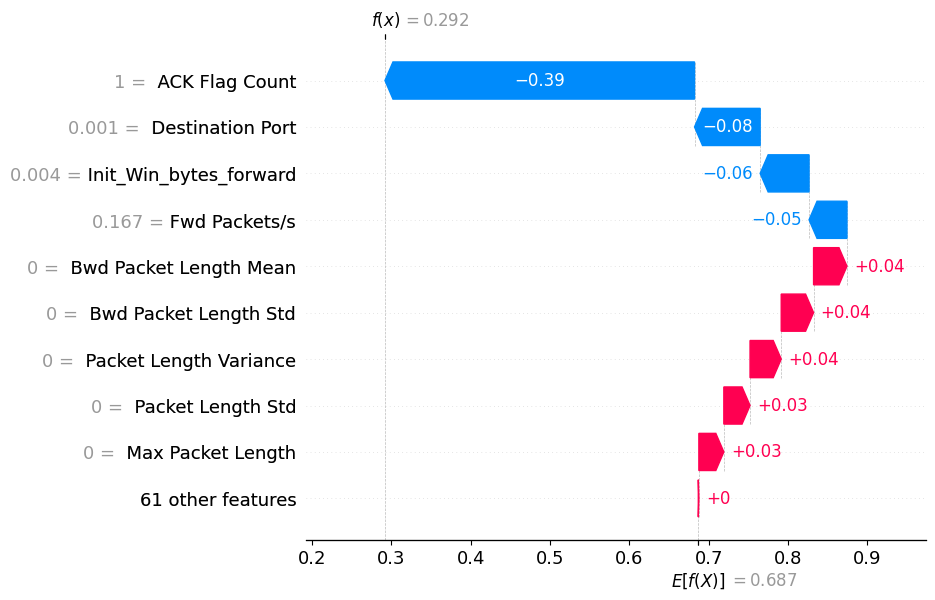

In [27]:
print(y_pred_adv[misclassified_adversarial_indices][0])

# plot explanations from misclassified samples
shap.waterfall_plot(adv_shap_values[misclassified_adversarial_indices[0]])

0


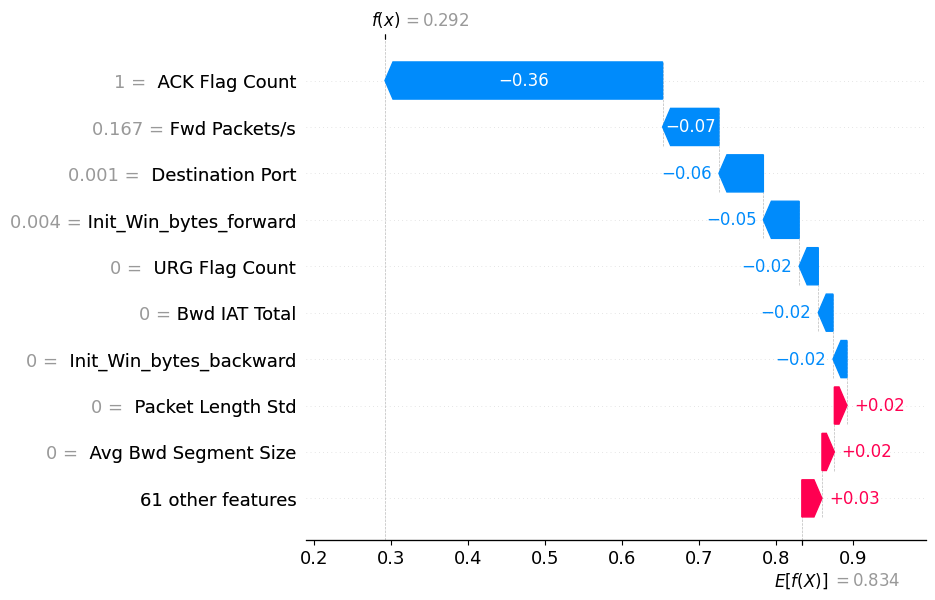

In [28]:
print(y_pred[misclassified_adversarial_indices][0])

# plot explanation from correct classified samples
shap.waterfall_plot(shap_values[misclassified_adversarial_indices][0])

## ***Finding***: *Explanations are similar but Prediction is different! -> Explanation do not match to prediction!*

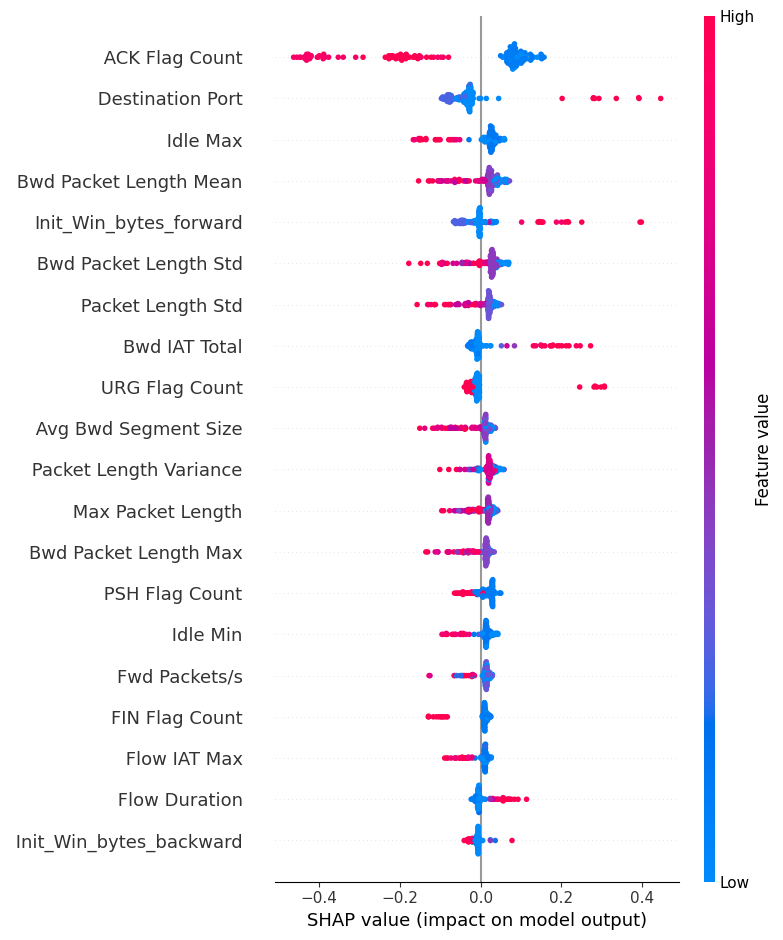

In [29]:
# plot
X_test_adv_np = np.array(X_test_adv)
shap.summary_plot(adv_shap_values[misclassified_adversarial_indices], X_test_adv_np[misclassified_adversarial_indices])